### scratch work to build `diffcolor` experiment
training using white pieces, predict on black pieces



In [3]:
from fastai2.vision.all import *
import time
import copy
import pickle
import sys
sys.path.append('..')

In [101]:
%load_ext autoreload
%autoreload 2

from modules.trainutils import (init_trainer, 
                                grid_exp,
                                stratify_sample,
                                piece_class_parse, 
                                only_class_parse,
                                my_acc
                               )

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [117]:
path = Path('../../../rf-chess-data/cropped_v1/')

##### Build dataloaders

In [118]:
test_seed = 42
test_n = 100
color='white'

white = ImageDataLoaders.from_name_func(
                path, 
                stratify_sample(path, 
                                n=test_n, 
                                np_seed=test_seed,
                                color = color,
                               ),
                valid_pct=0.0, 
                seed=None,# randomSplitter has no effect
                label_func=only_class_parse, 
                item_tfms=RandomResizedCrop(128, min_scale=0.5),
                batch_tfms=aug_transforms(),
                )

In [119]:
# white.show_batch()

In [127]:
train_seed, split_seed = 42, 22
train_n = 300
color='black'

black = ImageDataLoaders.from_name_func(
                path, 
                stratify_sample(path, 
                                n=train_n,
                                np_seed=train_seed,
                                color = color,
                               ),
                valid_pct=0.33, 
                seed=split_seed,
                label_func=only_class_parse, 
                item_tfms=RandomResizedCrop(128, min_scale=0.5),
                batch_tfms=aug_transforms(),
                )

##### Demo training

In [128]:
learn = cnn_learner(black, resnet18, metrics=error_rate)

In [129]:
learn.fine_tune(6)

epoch,train_loss,valid_loss,error_rate,time
0,3.216953,3.084642,0.717172,00:12


epoch,train_loss,valid_loss,error_rate,time
0,1.894198,1.513851,0.454545,00:17
1,1.587089,0.635368,0.232323,00:16
2,1.278161,0.215660,0.090909,00:16
3,1.072047,0.079141,0.040404,00:16
4,0.935457,0.047213,0.010101,00:16
5,0.832773,0.039721,0.010101,00:16


### Evaluate on Test

In [133]:
learn.cbs = L([])

In [134]:
my_acc(learn, white)

(0.9751243781094527, 0.53125)

##### Default ClassInterpretation
uses the learner's validation to score against

In [156]:
ci = ClassificationInterpretation.from_learner(
                                        learn, )

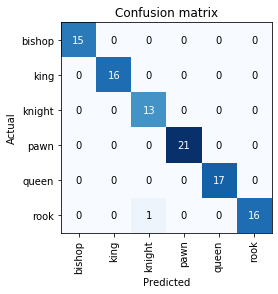

In [157]:
ci.plot_confusion_matrix()

##### ClassInterpretation on Train
use `ds_idx=0` to select training dataset for evaluation

note how there are more samples here since valid_pct = 0.33

In [158]:

ci = ClassificationInterpretation.from_learner(
                                        learn, 
                                        ds_idx=0,)

In [154]:
# another way to do the same thing...
# train_dl = learn.dls[0]
# ci = ClassificationInterpretation.from_learner(
#                                         learn, 
#                                         dl=train_dl)

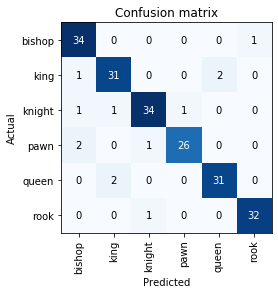

In [159]:
ci.plot_confusion_matrix()

##### Classification with a non-learner Test Set
here we input the `white` DataLoader

In [160]:
ci = ClassificationInterpretation.from_learner(
                                        learn, 
                                        dl=white.train)

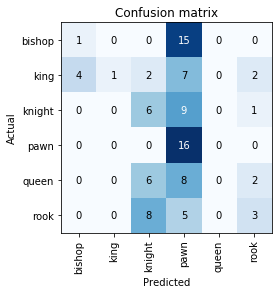

In [161]:
ci.plot_confusion_matrix()

##### Other ClassInterpretation Methods
we can use this class for getting metrics we want within our training loop / grid-search

In [166]:
ci.losses.mean()

tensor(2.2932)

In [167]:
ci.vocab

(#6) ['bishop','king','knight','pawn','queen','rook']

In [168]:
ci.print_classification_report()

              precision    recall  f1-score   support

      bishop       0.20      0.06      0.10        16
        king       1.00      0.06      0.12        16
      knight       0.27      0.38      0.32        16
        pawn       0.27      1.00      0.42        16
       queen       0.00      0.00      0.00        16
        rook       0.38      0.19      0.25        16

    accuracy                           0.28        96
   macro avg       0.35      0.28      0.20        96
weighted avg       0.35      0.28      0.20        96



/home/user/anaconda3/envs/fastai2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


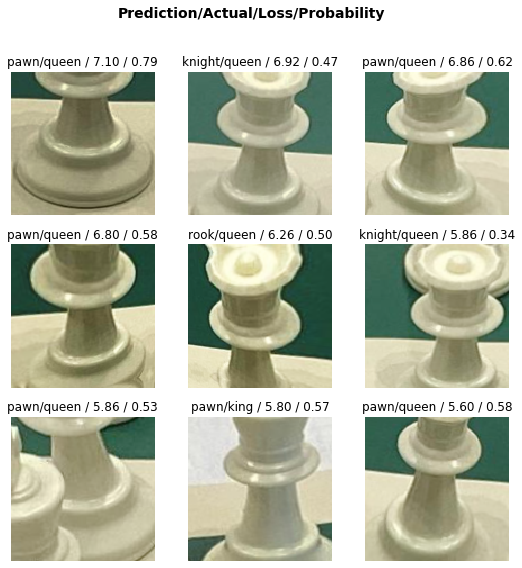

In [162]:
ci.plot_top_losses(9)